A notebook for finding detection hyperparameters by optimizing the F1 score between the data in obj_data_root and the detector predictions.

In [ ]:
# Imports
import random
import shutil
import numpy as np
random.seed(342)

# Code paths
import os
import sys
sys.path.append(os.path.split(os.getcwd())[0] + '\\helpers')
sys.path.append(os.path.split(os.getcwd())[0] + '\\associator\\CompTrack\\')
sys.path.append(os.path.split(os.getcwd())[0] + '\\evaluation\\py-motmetrics')

from file_utils import create_salmon_tracking_config_file, create_detector_MOT_results
from motmetrics_evaluation import evaluate_tracker_motmetrics
from motmetrics_evaluation import evaluate_tracker_motmetrics
from plot_utils import find_best_detector_settings


In [ ]:
# Specify tracker hyperparameters

### Paths and tracker type
salmon_tracking_root = r'C:\\Users\\espen\\Documents\\work\\PhD\\papers\\salmon_tracking\\data\\'
detection_model_path = r'C:\\Users\\espen\\Documents\\work\\PhD\\papers\\salmon_tracking\\data\\detector\\keybox_detection\\YOLO_models\\keybox_detection\\train18_model5\\weights\\best.pt'

# Use training data
obj_data_root = 'C:\\Users\\espen\\Documents\\work\\PhD\\papers\\salmon_tracking\\data\\datasets\\with_framewise_salmon_IDs\\CS_train\\'
video_path = r"C:\\Users\\espen\\Documents\\work\\PhD\\papers\\salmon_tracking\\data\\videos\\GH010031.mp4"

# Number of new optimizatino loops
num_optim_iterations = 100

# Detector and associator
associator = None # BoostTrack, CompTrack or BoostCompTrack
detector = 'keybox_detection' # keybox_detection or bounding_box_detection
detector_name = 'train18_model5'
use_embedding = None         # Whether to use person re-id embedding. Only available for BoostTrack and BoostCompTrack

### Input video parameters
start_frame =   2000 #30 #(0*60 + 51)*30  #(6*60 + 52)*30
end_frame =     5000 #7030 #(1*60 + 11)*30 #(6*60 + 54)*30
video_shape = [4242,4242] #[1224,1024]
rotate = 135

### Detection model parameters
salmon_conf = None
salmon_iou = None

bp_conf = None
bp_loc = 5

### Tracking parameters
max_hidden_length = None

# BoostTrack and BoostCompTrack
min_hits = None
trk_det_min_iou_threshold = None

# CompTrack
CompTrack_max_cost = None

# Saving
saved_frames = np.arange(start_frame,end_frame + 1, 100).astype(int).tolist()
print(saved_frames)

# Drawing parameters
skeleton = [['head', 'dorsal_fin'], ['head', 'body'], ['head', 'pec_fin'], ['body', 'dorsal_fin'], ['dorsal_fin', 'adi_fin'], ['adi_fin', 'anal_fin'], ['adi_fin', 'tail_fin'], ['tail_fin', 'body'], ['tail_fin', 'anal_fin'], ['anal_fin', 'pelv_fin'], ['pelv_fin', 'body'], ['pelv_fin', 'pec_fin']]
component_colors = {'salmon': (200,100,50),'body': (0,255,0),'head': (255,0,0),'tail_fin': (255,0,255),'dorsal_fin': (0,0,255),'anal_fin': (0,255,255),'adi_fin': (255,255,0),'pelv_fin': (120,120,120),'pec_fin': (50, 100, 200)}
salmon_bbox_thickness = 6
bp_bbox_thickness = 4

# Naming parameters
project = r'salmon_tracking'
bodyparts =            ['head', 'dorsal_fin', 'adi_fin', 'tail_fin', 'anal_fin','pelv_fin','pec_fin', 'body']
components = ['salmon', 'head', 'dorsal_fin', 'adi_fin', 'tail_fin', 'anal_fin','pelv_fin','pec_fin', 'body']
additional_kps = []

# Other
eps = 0.01

[2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000]



0: 1024x1024 26 salmons, 30.1ms
Speed: 9.3ms preprocess, 30.1ms inference, 66.8ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 27 salmons, 31.1ms
Speed: 7.6ms preprocess, 31.1ms inference, 4.0ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 26 salmons, 31.1ms
Speed: 7.5ms preprocess, 31.1ms inference, 5.2ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 32 salmons, 31.3ms
Speed: 12.2ms preprocess, 31.3ms inference, 9.9ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 33 salmons, 31.5ms
Speed: 7.8ms preprocess, 31.5ms inference, 4.1ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 36 salmons, 31.0ms
Speed: 10.9ms preprocess, 31.0ms inference, 3.0ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 32 salmons, 30.2ms
Speed: 7.0ms preprocess, 30.2ms inference, 3.1ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 48 salmons, 30.9ms
Speed: 7.3ms preprocess, 30.9ms inferenc

KeyboardInterrupt: 

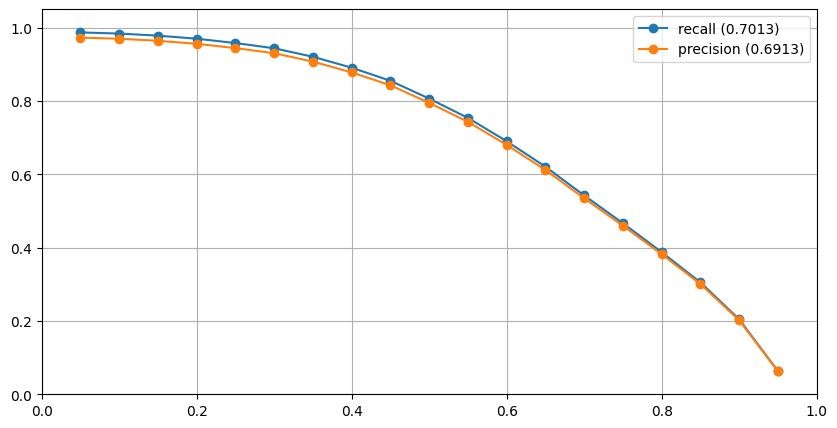

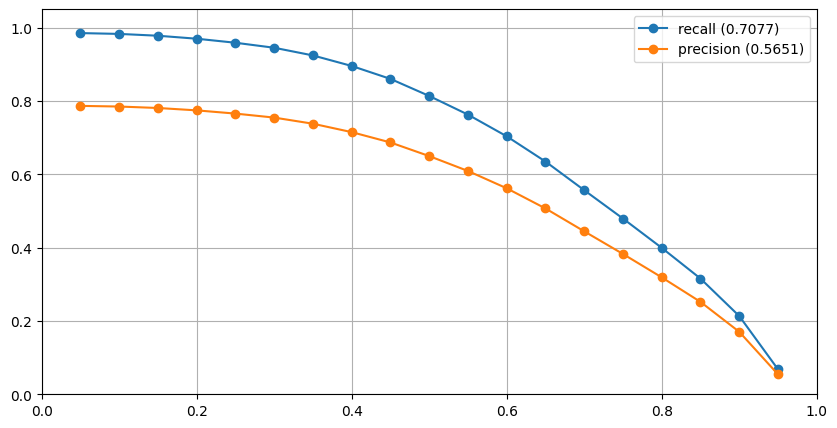

In [3]:
i = 0
while i < num_optim_iterations:
    salmon_conf = random.uniform(0.05,0.99)
    salmon_iou = random.uniform(0.05,0.99)
    bp_conf = random.uniform(0.05,0.99)

    # Update configuration file
    create_salmon_tracking_config_file(salmon_tracking_root,
                                    video_path,
                                    detection_model_path,
                                    associator,
                                    detector,
                                    use_embedding = use_embedding,
                                    project = project,
                                    start_frame = start_frame,
                                    end_frame = end_frame,
                                    video_shape = video_shape,
                                    rotate = rotate,                            
                                    salmon_conf = salmon_conf,
                                    bp_conf = bp_conf,
                                    bp_loc = bp_loc,
                                    salmon_iou = salmon_iou,
                                    max_hidden_length = max_hidden_length,
                                    CompTrack_max_cost = CompTrack_max_cost,
                                    bodyparts = bodyparts,
                                    component_colors = component_colors,
                                    skeleton = skeleton,
                                    saved_frames = saved_frames,
                                    eps = eps,
                                    salmon_bbox_thickness=salmon_bbox_thickness,
                                    bp_bbox_thickness=bp_bbox_thickness,
                                    min_hits = min_hits,
                                    trk_det_min_iou_threshold = trk_det_min_iou_threshold,
                                    components = components,
                                    detector_name = detector_name,
                                    additional_kps = additional_kps,
                                    )

    # Create detection results
    analysis_path = create_detector_MOT_results(salmon_tracking_root + r'\\config.yml')

    try:
        # Evaluate the results
        acc, summary, th_list, motmetrics_path, trackers, gt = evaluate_tracker_motmetrics(obj_data_root, analysis_path + '\\MOT_results.txt', frame_offset = 0, splitter = '_frame_', scramble_ids = True, metrics = ['recall', 'precision'])
        i = i+1
    except:
        shutil.rmtree(analysis_path)
    

The best detector settings are: 
salmon_conf: 0.64,
bp_conf: 0.6,
salmon_iou: 0.51


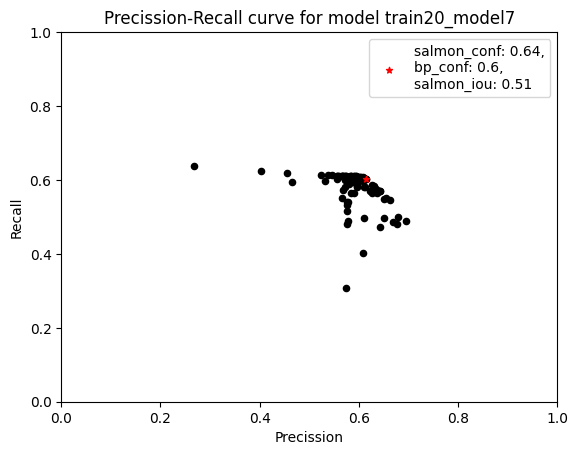

In [ ]:
find_best_detector_settings(salmon_tracking_root)

In [ ]:

# def find_best_detector_settings(salmon_tracking_root):
#     fig, ax = plt.subplots(1,1)

#     # Open last used config file
#     with open(salmon_tracking_root + '\\config.yml', 'r') as f:
#         config = yaml.safe_load(f)

#     # Store information about best settings
#     best_pres_rec = [0.01,0.01]
#     best_params = []

#     detector_results_root = salmon_tracking_root + '\\detector_optimization\\' + config['detector_name']
    
#     # Iterate over all tested settings
#     for analysis_folder in os.listdir(detector_results_root):
#         if not analysis_folder.split('\\')[-1].startswith('analysis'):
#             continue

#         # Load results
#         res = {}
#         with open(detector_results_root + '\\' + analysis_folder + '\\' + 'motmetrics_evaluation' + '\\' + 'results.txt', 'r') as f:
#             for line in f:
#                 line = line.split(',')
#                 res[line[0]] = [float(l) for l in line[1:]]

#         # Load config file
#         with open(detector_results_root + '\\' + analysis_folder + '\\' + 'config.yml', 'r') as f:
#             config = yaml.safe_load(f)
        
#         # Extract recall and precission
#         pres = np.average(np.array(res['precision']))
#         rec = np.average(np.array(res['recall']))

#         # Check F1 score
#         if 2*(best_pres_rec[0]*best_pres_rec[1])/(best_pres_rec[0]+best_pres_rec[1]) < 2*(pres*rec)/(pres+rec):
#             best_pres_rec[0] = pres
#             best_pres_rec[1] = rec
#             best_params = 'salmon_conf: ' + str(round(config['salmon_conf'], 2)) + ',\nbp_conf: ' + str(round(config['bp_conf'], 2)) + ',\nsalmon_iou: ' + str(round(config['salmon_iou'], 2))
        
#         # Plot point on precission-recall curve
#         ax.scatter(pres, rec, s = 20, c = 'k')

#     ax.scatter(best_pres_rec[0], best_pres_rec[1], marker = '*', s = 20, c = 'r', label = best_params)

#     ax.set_xlim(0.1,0.8)
#     ax.set_ylim(0.1,0.8)
#     ax.set_xlabel('Precission')
#     ax.set_ylabel('Recall')
#     ax.set_title('Precission-Recall curve for model ' + config['detector_name'])
#     print('The best detector settings are: ')
#     print(best_params)
#     ax.legend()
#     fig.savefig(detector_results_root + '\\result.png')


In [ ]:
# def create_detector_MOT_results(config_file_path):
#     '''
#     Write a MOT_results.txt file to the analysis folder. Each detection is given a new ID.

#     Args:
#         config_file_path (str): Path to the config file
#     Operations:
#         Generate a folder as specified by the config file, where all tracking information is stored
#         Generates an annotated video displaying the tracking behaviour. Saves this video to disk.
#         Generates images displaying the tracking behaviour. Saves this video to disk.
#         Generates a .txt file on the MOT format with tracking information.
#     '''
#     id_cnt = 1
#     # Create analysis folder
#     config, analysis_path = create_folders_for_detector_optimization(config_file_path)

#     # Specify names of input and output video
#     #input_video_name = config['video_path'].split('\\')[-1].split('.')[0]

#     # Set up video stream
#     cap = cv2.VideoCapture(config['video_path'])

#     # Specify start frame
#     #frame_num = config['start_frame']
#     #cap.set(cv2.CAP_PROP_POS_FRAMES, config['start_frame'])

#     # Set up detection model
#     if config['detector'] == 'keybox_detection':
#         detection_model = ultralytics.YOLO(config['detection_model_path'], task = 'pose')
#     else:
#         detection_model = ultralytics.YOLO(config['detection_model_path'])

#     # Initialize results list
#     results = []
#     print('start')

#     for frame_num in config['saved_frames']:
#         frame_num = frame_num + config['start_frame']
#         cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)

#         success, frame = cap.read()
        
#         if not success:
#             print('Cannot read frame')
#             break
        
#         # Rotate frame
#         if config['rotate'] != 0:
#             frame = imutils.rotate_bound(frame, config['rotate']).astype(np.uint8)
#         # Retrieve detections
#         detections = YOLO2CompTrack(detection_model(frame, iou=config['salmon_iou'], conf = config['salmon_conf'], agnostic_nms = False), config) # Shape Nsal X Nbp X 5
#         plot_targets = []

#         # Update results list
#         for salmon, id in zip(detections, range(detections.shape[0])):
#             for comp, comp_type in zip(salmon, range(salmon.shape[0])):
#                 bblbbtwh = ku.xyxy2bblbbtwh(comp[0:4])
#                 conf = comp[4]
#                 comp_id = get_comp_id_from_salmon_ID_and_comp_type(id_cnt + id, comp_type)
#                 #id = id_cnt
#                 #id_cnt = id_cnt + 1
#                 if conf > config['eps']:
#                     results.append([str(int(frame_num)), str(int(comp_id))] + [str(l) for l in bblbbtwh] + [str(conf)] + ['-1', '-1', '-1'] + [config['components'][int(comp_type)]])
#                     plot_targets.append([comp[0], comp[1], comp[2], comp[3], comp_id, conf, comp_type])
#         id_cnt = id_cnt + detections.shape[0]
#         # Check termination criterion
#         #frame_num = frame_num + 1
#         #if frame_num > config['end_frame']:
#         #    break
        
#         #aframe = annotate_frame(np.array(plot_targets), frame, frame_num, config, True)
#         #cv2.imwrite(analysis_path + '\\' + str(frame_num) + '.png', aframe)
#         #break

#     # Release video operations
#     cap.release()
#     # Save results to disk
#     write_MOT_results(results, analysis_path)

#     return analysis_path

#analysis_path = create_detector_MOT_results(config_file_path)

In [ ]:
#analysis_path = 'C:\\Users\\espen\\Documents\\work\\salmon_welfare_monitoring\\data\\salmon_component_tracking\\detector_optimization\\train2_model3\\analysis109\\'

In [ ]:
#evaluate_tracker_motmetrics(obj_data_root, analysis_path + '\\MOT_results.txt', frame_offset = 0, splitter = '_frame_', scramble_ids = True)